## Identifiability Test of nonlinear SSA on Synthetic Dataset

In [320]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [321]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import leap
import numpy as np
from leap.datasets.sim_dataset import DANS
from leap.modules.sssa import SSA
from leap.tools.utils import load_yaml
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [397]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")
latent_size = 4
content_size = 3
style_size = 1

In [392]:
data = DANS(directory = '/srv/data/ltcl/data/', 
            dataset='da_gau_5')
num_validation_samples = 4096
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=25600, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [393]:
cfg = load_yaml('../leap/configs/toy_gau_5.yaml')

In [394]:
model = SSA.load_from_checkpoint(
            checkpoint_path="/srv/data/ltcl/log/weiran/toy_gau_5/lightning_logs/version_31/checkpoints/epoch=62-step=16442.ckpt",
            input_dim=cfg['VAE']['INPUT_DIM'],
            c_dim=cfg['VAE']['CONTENT_DIM'],
            s_dim=cfg['VAE']['STYLE_DIM'],
            nclass=cfg['VAE']['NCLASS'],
            hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
            bound=cfg['SPLINE']['BOUND'],
            count_bins=cfg['SPLINE']['BINS'],
            order=cfg['SPLINE']['ORDER'],
            beta=cfg['VAE']['BETA'],
            gamma=cfg['VAE']['GAMMA'],
            sigma=cfg['VAE']['SIGMA'],
            lr=cfg['VAE']['LR'],
            use_warm_start=cfg['SPLINE']['USE_WARM_START'],
            spline_pth=cfg['SPLINE']['PATH'],
            decoder_dist=cfg['VAE']['DEC']['DIST'],
            correlation=cfg['MCC']['CORR'])

Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow


/home/weiran/project/leap/leap/modules/components/beta.py:291: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [395]:
model.eval()

SSA(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Linear(in_features=4, out_features=128, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (spline_list): ModuleList(
    (0): ComponentWiseSpline()
    (1): ComponentWiseSpline()
    (2): ComponentWiseSpline()
    (3): ComponentWiseSpline()
    (4): ComponentWiseSpline()
  )
  (hsic): RbfHSIC()
)

In [396]:
model.to('cpu')

SSA(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Linear(in_features=4, out_features=128, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (spline_list): ModuleList(
    (0): ComponentWiseSpline()
    (1): ComponentWiseSpline()
    (2): ComponentWiseSpline()
    (3): ComponentWiseSpline()
    (4): ComponentWiseSpline()
  )
  (hsic): RbfHSIC()
)

In [398]:
for batch in train_loader:
    break

In [399]:
batch_size = batch['x'].shape[0]

In [400]:
from scipy.stats import spearmanr

### Visualize style components

In [402]:
A

array([[0.35468027],
       [0.45787498],
       [0.3799961 ],
       ...,
       [0.37803057],
       [0.0579499 ],
       [0.46347943]], dtype=float32)

In [405]:
B.shape

(25600, 1)

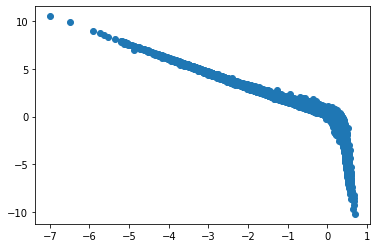

In [404]:
plt.scatter(A,B)

In [406]:
np.abs(spearmanr(B, A).correlation)

0.973207019390085

In [401]:
zs, mu, logvar = model.forward(batch)
mu = mu.view(batch_size, latent_size)
A = mu[:,-style_size:].detach().cpu().numpy()
B = batch['y'][:,-style_size:].detach().cpu().numpy()
C = np.zeros((style_size,style_size))
for i in range(style_size):
    C[i] = -np.abs(spearmanr(B, A).correlation[i,style_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(style_size)
for i in range(style_size):
    if np.corrcoef(B, A, rowvar=False)[i,style_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

IndexError: invalid index to scalar variable.

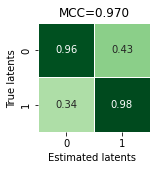

In [334]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("Estimated latents ") 
plt.ylabel("True latents ") 
plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());

In [335]:
A = mu[:,:].detach().cpu().numpy()
B = batch['y'][:,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))

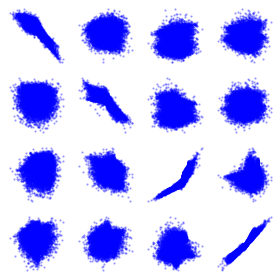

In [336]:
fig, axs = plt.subplots(latent_size,latent_size, figsize=(4,4))
for i in range(latent_size):
    for j in range(latent_size):
        ax = axs[i, j]
        ax.scatter(B[:,i], A[:,j], s=2, color='b', alpha=0.25)
        ax.axis('off')
#     ax.set_xlabel('Ground truth latent')
#     ax.set_ylabel('Estimated latent')
#     ax.grid('..')
# plt.xlabel("True (4 content + 4 style)")
# plt.ylabel("Estimated (4 content + 4 style)")
fig.tight_layout()

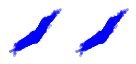

In [338]:
fig, axs = plt.subplots(1,2, figsize=(2,1))
for i in range(style_size):
    ax = axs[i]
    ax.scatter(B[:,-style_size:], A[:,-style_size:], s=4, color='b', alpha=0.25)
    ax.axis('off')
#     ax.set_xlabel('Ground truth latent')
#     ax.set_ylabel('Estimated latent')
#     ax.grid('..')
fig.tight_layout()

### Visualize content components

In [380]:
Y = mu[:,:content_size].detach().cpu().numpy()
X = batch['y'][:,:].detach().cpu().numpy()

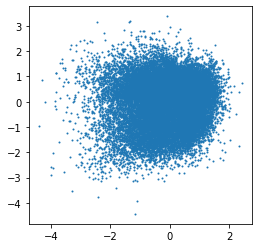

In [390]:
fig = plt.figure(figsize=(4,4))
plt.scatter(Y[:,0], Y[:,1], s=1)

In [381]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [383]:
rf = RandomForestRegressor()

In [384]:
rf.fit(X_train, y_train)
Y_pred = rf.predict(X)

In [385]:
print("R2: %.3f"%rf.score(X_test, y_test))

R2: 0.985


In [345]:
n_samples = 100

Text(0.5, 0, '1st dimension')

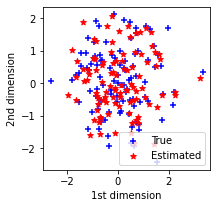

In [346]:
plt.figure(figsize=(3,3))
plt.scatter(Y[:n_samples,0], Y[:n_samples,1], marker="+", label='True', color='b')
plt.scatter(Y_pred[:n_samples,0], Y_pred[:n_samples,1], marker='*', label='Estimated', color='r')
plt.legend()
plt.ylabel('2nd dimension')
plt.xlabel('1st dimension')

In [306]:
np.random.seed(1)
Ncomp_s=4
Nsegment=10
Nsegment=10
modMat = np.random.uniform(0., 1, (Ncomp_s, Nsegment))

In [ ]:
hidden=20
n_sample=1500

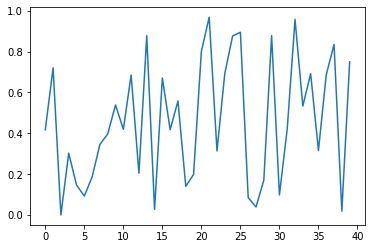

In [308]:
plt.plot(modMat.reshape(-1))